## Paso al Modelado Predictivo

Tras el análisis exploratorio (EDA), identificamos patrones relevantes asociados a la baja de clientes:

- Contratos mes a mes presentan mayor abandono.
- Baja antigüedad incrementa el riesgo.
- Métodos de pago específicos muestran mayor churn.
- Cargos elevados combinados con poca permanencia aumentan la probabilidad de abandono.

El siguiente paso es construir modelos predictivos que permitan:

> Estimar la probabilidad de baja antes de que ocurra.

Para ello, se probarán distintos algoritmos de clasificación y se comparará su rendimiento.


Importación de librerias

In [173]:
import pandas as pd # Librería de lectura de datos
import numpy as np # Librería de cálculo numérico


import matplotlib.pyplot as plt # Librería de visualización de datos

from sklearn.model_selection import train_test_split,GridSearchCV # Función para dividir los datos en entrenamiento y prueba
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,plot_tree, export_text

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve # Funciones para evaluar el rendimiento del modelo

from sklearn.feature_selection import (VarianceThreshold, SelectKBest,
                                      f_classif, RFE, SelectFromModel)
from sklearn import svm
from sklearn.metrics import confusion_matrix as cm_func
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix as cm_func2
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.metrics import confusion_matrix as cm_func3

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler

Carga del dataset

In [174]:
df = pd.read_parquet('../clean_data/telco-customer.parquet')

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  7043 non-null   category
 1   seniorcitizen           7043 non-null   category
 2   partner                 7043 non-null   category
 3   dependents              7043 non-null   category
 4   tenure                  7043 non-null   int64   
 5   phoneservice            7043 non-null   category
 6   multiplelines           7043 non-null   category
 7   internetservice         7043 non-null   category
 8   onlinesecurity          7043 non-null   category
 9   onlinebackup            7043 non-null   category
 10  deviceprotection        7043 non-null   category
 11  techsupport             7043 non-null   category
 12  streamingtv             7043 non-null   category
 13  streamingmovies         7043 non-null   category
 14  contract                

In [176]:
df_copy = df.copy()

## Transformación de Variables

Antes de entrenar modelos de Machine Learning es necesario convertir las variables categóricas en formato numérico.

Los algoritmos de clasificación no pueden trabajar directamente con texto como:

- "Month-to-month"
- "Fiber optic"
- "Electronic check"

Por ello aplicamos:

- **Label Encoding** para la variable objetivo (`baja`)
- **One Hot Encoding** para las variables categóricas predictoras

### 🔹 ¿Por qué usar Label Encoding en la variable objetivo?

Porque se trata de una variable binaria (Sí / No) y solo necesitamos convertirla a:

- 1 → Cliente se da de baja
- 0 → Cliente permanece

### 🔹 ¿Por qué usar One Hot Encoding en las variables categóricas?

Porque evita introducir relaciones ordinales artificiales.

Por ejemplo:

Tipo de contrato:
- Month-to-month
- One year
- Two year

No existe jerarquía numérica entre ellas, por lo que asignar 1, 2, 3 generaría una relación falsa.

One Hot Encoding crea columnas binarias independientes para cada categoría.


### One hot enconding

In [177]:
# Iniciliar one hot enconder
enconder = OneHotEncoder(sparse_output=False, dtype=int)

# Obtenemos las variables categóricas
cols_categoricas = df_copy.select_dtypes(include='category').columns
#print(cols_categoricas)

#Eliminamos la variable objetivo
cols_categoricas = cols_categoricas.drop('baja')
#print(cols_categoricas)

#Aplicar One Hot Encoding a las columnas categóricas
enconded = enconder.fit_transform(df_copy[cols_categoricas])

# Obtenemos el nombre de las nuevas columnas
column_names = enconder.get_feature_names_out(cols_categoricas)

# Creación del dataframe con valores codificados
df_encoded = pd.DataFrame(enconded,columns=column_names,index=df_copy.index)
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   gender_Female                            7043 non-null   int64
 1   gender_Male                              7043 non-null   int64
 2   seniorcitizen_SeniorCitizen              7043 non-null   int64
 3   seniorcitizen_noSeniorCitizen            7043 non-null   int64
 4   partner_No                               7043 non-null   int64
 5   partner_Yes                              7043 non-null   int64
 6   dependents_No                            7043 non-null   int64
 7   dependents_Yes                           7043 non-null   int64
 8   phoneservice_No                          7043 non-null   int64
 9   phoneservice_Yes                         7043 non-null   int64
 10  multiplelines_No                         7043 non-null   int64
 11  mult

### Label Enconding 

In [178]:
# Aplicar label enconder
label_encoder = LabelEncoder()
target_var = df_copy['baja']
#print(target_var)
target_var = label_encoder.fit_transform(target_var)
print(target_var)


[0 0 1 ... 0 1 0]


## Reconstrucción del Dataset Final para Modelado

Tras aplicar las transformaciones necesarias:

- Variables numéricas se mantienen sin cambios.
- Variables booleanas se conservan en formato binario.
- Variables categóricas han sido transformadas mediante One Hot Encoding.
- La variable objetivo ha sido codificada como binaria.

El siguiente paso es reconstruir un único dataframe que contenga:

1. Variable objetivo (`baja`)
2. Variables numéricas
3. Variables booleanas
4. Variables categóricas codificadas

Este dataframe será la base para entrenar los modelos de Machine Learning.

In [179]:
# Obtenemos las variables numéricas
columns_num_int = df_copy.select_dtypes(include='int64').columns
print(columns_num_int)

columns_num_float = df_copy.select_dtypes(include='float64').columns
print(columns_num_float)

#Obtenemos las variables booleanas
colums_bool = df_copy.select_dtypes(include='bool').columns
print(colums_bool)

Index(['tenure'], dtype='object')
Index(['monthlycharges', 'totalcharges'], dtype='object')
Index(['cliente_larga_duracion', 'phone_and_internet'], dtype='object')


In [180]:
#Unimos todas los datos en un dataframe
column_target = pd.Series(target_var, name='baja', index=df_copy.index)


X_num_int   = df_copy[columns_num_int]
X_num_float = df_copy[columns_num_float]
X_bool      = df_copy[colums_bool]

df_final = pd.concat([column_target, X_num_int, X_num_float, X_bool, df_encoded], axis=1)

df_final.head()



,baja,tenure,monthlycharges,totalcharges,cliente_larga_duracion,phone_and_internet,gender_Female,gender_Male,seniorcitizen_SeniorCitizen,seniorcitizen_noSeniorCitizen,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0,1,29.85,29.85,False,False,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,True,True,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,1,2,53.85,108.15,False,True,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,True,False,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,1,2,70.70,151.65,False,True,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


## Separación de Variable Objetivo y Variables Predictoras

Una vez construido el dataframe final con todas las transformaciones aplicadas, el siguiente paso es separar:

- **Variable objetivo (`baja`)** → lo que queremos predecir.
- **Variables predictoras (`X`)** → características que utilizará el modelo para hacer la predicción.

Esta separación es fundamental porque los modelos de Machine Learning necesitan:

- Un conjunto de entrada (features)
- Una variable de salida (target)

In [181]:
#Separación entre variable objetivo y las demás
#Demás variables
X = df_final.drop(columns='baja')
#X.info()
#Variable objetivo
Y = df_final['baja']

## División del Dataset

Se divide el dataset en:

- 70% → conjunto de entrenamiento
- 30% → conjunto de prueba

Se utiliza `stratify=Y` para mantener la proporción original de clientes que se dan de baja y los que no, evitando sesgos en la evaluación del modelo.

A partir de este punto, los modelos se entrenarán únicamente con los datos de entrenamiento y se evaluarán con los datos de prueba.

In [182]:
#Divisíon 70%/30%
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

## Análisis de Importancia de Variables

Aunque no se aplicó una reducción formal de variables para el entrenamiento final del modelo, se realizó un análisis de importancia de características con el objetivo de:

- Identificar qué variables influyen más en la predicción.
- Validar los hallazgos obtenidos durante el EDA.
- Obtener insights accionables para negocio.

Este análisis permite interpretar el modelo y entender qué factores están más relacionados con la baja de clientes.


Variables tras ANOVA: 48


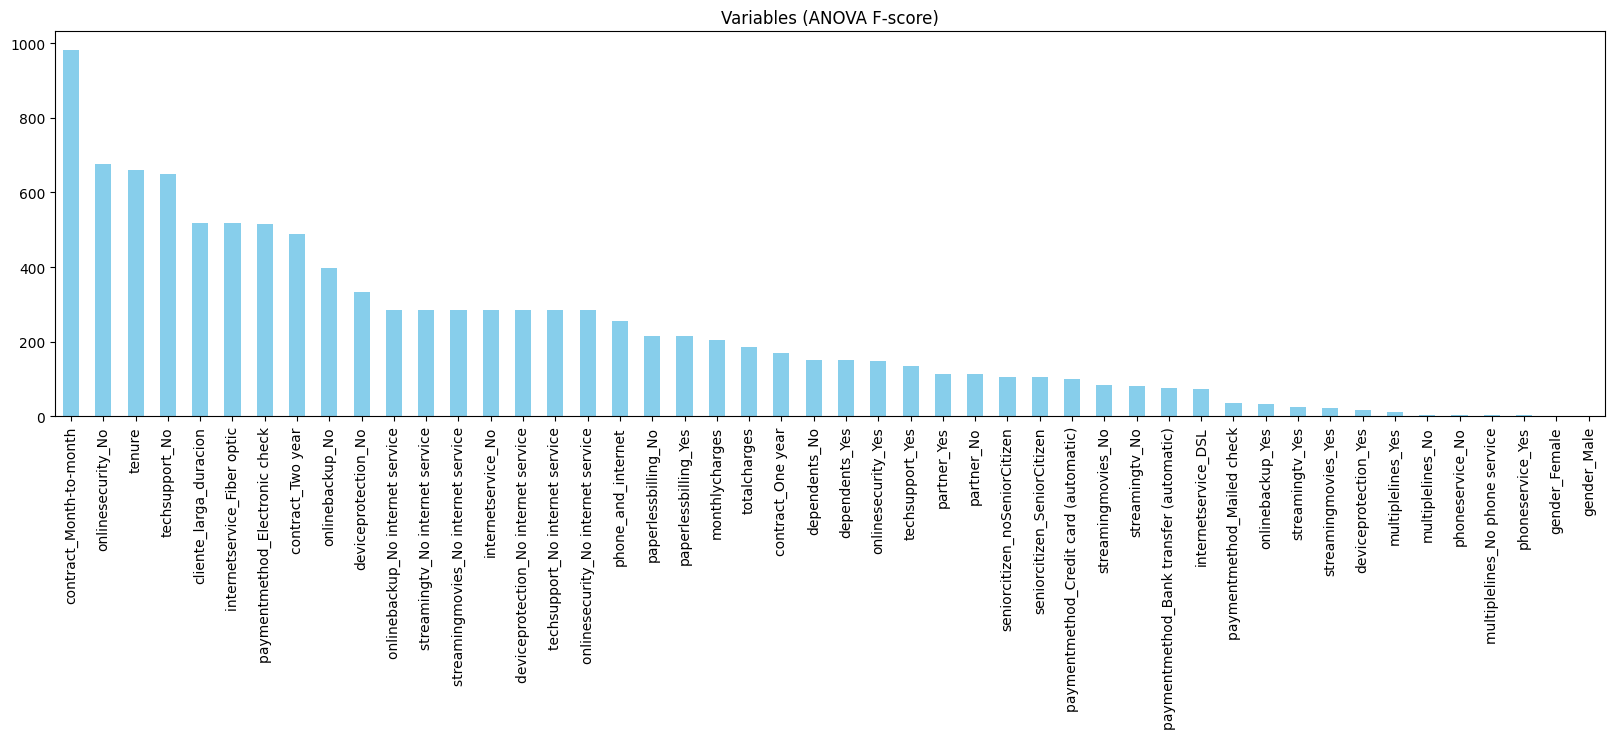

In [183]:
# Filtro Estadístico (ANOVA)
selector_kbest = SelectKBest(score_func=f_classif, k='all')
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

print(f"Variables tras ANOVA: {X_train_kbest.shape[1]}")

# Visualización de importancia estadística
scores = pd.Series(selector_kbest.scores_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(20, 5))
scores.plot(kind='bar', color='skyblue')
plt.title("Variables (ANOVA F-score)")
plt.show()

##  Comparación de Algoritmos de Clasificación

Con el dataset preparado, se procede a entrenar y evaluar distintos modelos de clasificación con el objetivo de identificar cuál ofrece mejor rendimiento en la predicción de la baja de clientes.

Los algoritmos evaluados fueron:

- Regresión Logística
- Support Vector Machine (SVM)
- Árboles de Decisión
- K-Nearest Neighbors (KNN)
- Random Forest
- XGBoost

Esta comparación permite evaluar distintos enfoques:

- Modelos lineales
- Modelos basados en distancia
- Modelos basados en árboles
- Métodos de ensamblado (ensemble)


## Modelo 1: Regresión Logística

La regresión logística es un modelo lineal utilizado para problemas de clasificación binaria.

En este caso, permite estimar la probabilidad de que un cliente se dé de baja en función de sus características.

Este modelo es especialmente útil como punto de partida porque:

- Es interpretable.
- Permite analizar el impacto individual de cada variable.
- Sirve como baseline para comparar modelos más complejos.


In [184]:

#Crear modelo
modelo = LogisticRegression()
#Entrenar modelo
modelo.fit(X_train,y_train)

print("Intercepto (β0):", modelo.intercept_[0])
print("Coeficiente (β1):", modelo.coef_[0][0])

Intercepto (β0): -0.14077662042989167
Coeficiente (β1): -0.05737512511200509


c:\Users\camac\OneDrive\Escritorio\Proyecto-8-Problema-de-clasificacion-Grupo-3\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluación y Predicción del modelo

In [185]:
from sklearn.metrics import classification_report

y_pred = modelo.predict(X_test)
y_pred_prob = modelo.predict_proba(X_test)[:, 1]

confusion_matrix = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred, zero_division = 1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar las métricas
print("Matriz de Confusión:\n", confusion_matrix)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)

Matriz de Confusión:
 [[1402  150]
 [ 250  311]]
Precisión: 0.6746203904555315
Sensibilidad (Recall): 0.5543672014260249
F1 Score: 0.6086105675146771
AUC-ROC: 0.8448548936913097


## SVM

In [186]:
model_svm = svm.SVC(kernel="rbf",
    probability=True,
    class_weight="balanced")
model_svm.fit(X_train,y_train)

y_pred = model_svm.predict(X_test)
y_pred_prob = model_svm.predict_proba(X_test)[:, 1]

cm = cm_func(y_test,y_pred)
precision = precision_score(y_test,y_pred, zero_division = 1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar las métricas
print("Matriz de Confusión:\n", cm)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)


Matriz de Confusión:
 [[1103  449]
 [ 245  316]]
Precisión: 0.4130718954248366
Sensibilidad (Recall): 0.5632798573975044
F1 Score: 0.4766214177978884
AUC-ROC: 0.7205038177407794


## Arboles de decision

In [187]:
modelo_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
modelo_tree.fit(X_train, y_train)

y_pred = modelo_tree.predict(X_test)
y_pred_prob = modelo_tree.predict_proba(X_test)[:, 1]

cm2 = cm_func2(y_test,y_pred)
precision = precision_score(y_test,y_pred, zero_division = 1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar las métricas
print("Matriz de Confusión:\n", cm2)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)

Matriz de Confusión:
 [[1261  291]
 [ 279  282]]
Precisión: 0.49214659685863876
Sensibilidad (Recall): 0.5026737967914439
F1 Score: 0.4973544973544973
AUC-ROC: 0.6585545417792235


## K-nearest Neighbour(KNN)

In [188]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)[:, 1]

cm2 = cm_func3(y_test,y_pred)
precision = precision_score(y_test,y_pred, zero_division = 1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar las métricas
print("Matriz de Confusión:\n", cm2)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)

Matriz de Confusión:
 [[1357  195]
 [ 317  244]]
Precisión: 0.5558086560364465
Sensibilidad (Recall): 0.43493761140819964
F1 Score: 0.488
AUC-ROC: 0.7190227778084055


## Random forest

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"  
)

# Entrenamos
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Métricas
cm_rf = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar resultados
print("Matriz de Confusión:\n", cm_rf)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)


Matriz de Confusión:
 [[1387  165]
 [ 297  264]]
Precisión: 0.6153846153846154
Sensibilidad (Recall): 0.47058823529411764
F1 Score: 0.5333333333333333
AUC-ROC: 0.8163975641803111


## XGBoost

In [190]:

# Definimos el modelo XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

# Entrenamos
xgb.fit(X_train, y_train)

# Predicciones
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

# Métricas
cm_xgb = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)
auc = roc_auc_score(y_test, y_pred_prob)

# Mostrar resultados
print("Matriz de Confusión:\n", cm_xgb)
print("Precisión:", precision)
print("Sensibilidad (Recall):", recall)
print("F1 Score:", f1)
print("AUC-ROC:", auc)


Matriz de Confusión:
 [[1396  156]
 [ 279  282]]
Precisión: 0.6438356164383562
Sensibilidad (Recall): 0.5026737967914439
F1 Score: 0.5645645645645646
AUC-ROC: 0.837059191061617


## Comparación de Modelos de Clasificación

Una vez preparado el dataset (codificación de variables categóricas y separación en train/test), se entrenaron distintos algoritmos de clasificación para predecir si un cliente se dará de baja.

El objetivo de esta fase es **comparar modelos entre sí** de forma homogénea, usando el mismo conjunto de entrenamiento y prueba, y quedarnos con el que ofrezca mejor equilibrio entre rendimiento e interpretabilidad.

### ¿Por qué comparar varios algoritmos?
Cada familia de modelos captura patrones distintos:
- **Modelos lineales** (Regresión Logística): simples, interpretables y buenos como baseline.
- **Modelos por distancia** (KNN): sensibles a la escala, detectan similitud entre clientes.
- **Modelos con márgenes** (SVM): pueden capturar fronteras complejas.
- **Árboles y ensembles** (Árbol, Random Forest, XGBoost): capturan relaciones no lineales e interacciones entre variables.

### Métricas usadas
En un problema de churn no basta con “acertar mucho”, porque puede haber desequilibrio entre clases. Por eso se evalúa:

- **Precision (Precisión):** de los clientes predichos como baja, cuántos realmente se dan de baja.
- **Recall (Sensibilidad):** de los clientes que realmente se dan de baja, cuántos detecta el modelo.
- **F1-score:** equilibrio entre precisión y recall (métrica principal para comparar).
- **AUC-ROC:** capacidad general del modelo para separar ambas clases.
- **Matriz de confusión:** detalle de aciertos y errores (falsos positivos y falsos negativos).

Para automatizar la comparación, se utiliza una función `evaluar_modelo()` que entrena, predice y devuelve métricas para cada algoritmo.


In [191]:
def evaluar_modelo(nombre, model, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo, predice y devuelve un diccionario con métricas.
    """
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Probabilidades (si el modelo las soporta)
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)
    elif hasattr(model, "decision_function"):
        # Para modelos tipo SVC sin predict_proba (si no activaste probability=True)
        scores = model.decision_function(X_test)
        auc = roc_auc_score(y_test, scores)
    else:
        auc = None

    return {
        "Modelo": nombre,
        "Precision": precision_score(y_test, y_pred, zero_division=1),
        "Recall": recall_score(y_test, y_pred, zero_division=1),
        "F1-score": f1_score(y_test, y_pred, zero_division=1),
        "AUC-ROC": auc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# 1) Define aquí tus modelos (los que quieras)
modelos = {
    "Regresión logística": modelo,     # ejemplo: tu objeto ya creado
    "KNN": knn,
    "Árbol de decisión": modelo_tree,
    "SVC": model_svm,
    "Random Forest": rf,
    "XGBoost": xgb
}

# 2) Evalúa todos y guarda resultados
resultados = []
cms = {}

for nombre, modelo in modelos.items():
    res = evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test)
    cms[nombre] = res.pop("Confusion Matrix")  # guardamos CM aparte
    resultados.append(res)

# 3) Crea la tabla final ordenada por F1 (desc)
df_resultados = pd.DataFrame(resultados).sort_values("F1-score", ascending=False).reset_index(drop=True)

df_resultados

c:\Users\camac\OneDrive\Escritorio\Proyecto-8-Problema-de-clasificacion-Grupo-3\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Modelo,Precision,Recall,F1-score,AUC-ROC
0,Regresión logística,0.674620,0.554367,0.608611,0.844855
1,XGBoost,0.643836,0.502674,0.564565,0.837059
2,Random Forest,0.615385,0.470588,0.533333,0.816398
3,Árbol de decisión,0.492147,0.502674,0.497354,0.658555
4,KNN,0.555809,0.434938,0.488000,0.719023
5,SVC,0.413072,0.563280,0.476621,0.720502


## Resultados de la Comparación

A continuación se muestra la tabla de métricas ordenada por F1-score (de mayor a menor):

**Conclusión principal:** el modelo con mejor rendimiento global en este experimento es la **Regresión Logística**, con:
- **F1-score = 0.609**
- **AUC-ROC = 0.845** (el más alto)

Esto indica que, con el preprocesado actual, el patrón de churn se puede capturar muy bien con un modelo lineal, y además aporta una ventaja clave: **interpretabilidad**, ya que permite analizar qué variables incrementan o reducen el riesgo de baja.

### Lectura rápida por modelos
- **Regresión Logística (mejor modelo):** mejor equilibrio general entre precisión y recall.
- **XGBoost (2º):** muy competitivo, pero no supera el F1 de logística en este caso.
- **Random Forest (3º):** rendimiento correcto, pero por debajo del top 2.
- **SVC:** tiene recall relativamente alto (detecta más bajas), pero su precisión es baja → genera más falsos positivos.
- **KNN / Árbol de decisión:** rendimiento más bajo, probablemente por sensibilidad a escala (KNN) o falta de generalización (árbol).


## Optimización de Hiperparámetros con Optuna

Tras comparar los modelos con sus configuraciones por defecto, se procedió a optimizar sus hiperparámetros utilizando Optuna.

El objetivo fue mejorar el rendimiento ajustando automáticamente parámetros clave como profundidad, número de estimadores, regularización o vecinos, según el algoritmo.

La métrica utilizada para la optimización fue el **F1-score**, ya que equilibra precisión y recall, algo fundamental en un problema de churn.


### Regresión logística

In [192]:
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-4, 1e2, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": "liblinear",  # liblinear soporta l1 y l2 sin líos
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "max_iter": 2000,
        "random_state": 42
    }

    model = LogisticRegression(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # usa "f1" si es churn/baja; o "recall" si te interesa captar bajas
    scores = cross_val_score(model, X_scaled, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best F1:", study.best_value)
print("Best params:", study.best_params)


[I 2026-02-15 19:43:40,252] A new study created in memory with name: no-name-20d3771a-d9e5-4c57-ba93-81d20fac719e
[I 2026-02-15 19:43:43,482] Trial 0 finished with value: 0.601471038665272 and parameters: {'C': 1.7484520884527885, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.601471038665272.
[I 2026-02-15 19:43:45,891] Trial 1 finished with value: 0.6003630633624126 and parameters: {'C': 0.6982778765611962, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.601471038665272.
[I 2026-02-15 19:43:47,957] Trial 2 finished with value: 0.5228247199552652 and parameters: {'C': 0.003964558148698511, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.601471038665272.
[I 2026-02-15 19:43:48,228] Trial 3 finished with value: 0.6270646517329032 and parameters: {'C': 0.1766821120705594, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.6270646517329032.
[I 2026-02-15 19:43:48,376] Trial 4 finished with value: 0

Best F1: 0.6284306406768987
Best params: {'C': 0.059488195255723346, 'penalty': 'l1', 'class_weight': 'balanced'}


### KNN

In [193]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def objective(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 25),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    }

    model = KNeighborsClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X_scaled, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective, n_trials=50)

print("KNN best F1:", study_knn.best_value)
print("KNN best params:", study_knn.best_params)


[I 2026-02-15 19:44:01,889] A new study created in memory with name: no-name-de1383dd-9759-4760-b0c7-5a8f3997164c


[I 2026-02-15 19:44:02,407] Trial 0 finished with value: 0.5355533492801355 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.5355533492801355.
[I 2026-02-15 19:44:02,916] Trial 1 finished with value: 0.5101255755626848 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.5355533492801355.
[I 2026-02-15 19:44:03,180] Trial 2 finished with value: 0.5851711398302564 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 2 with value: 0.5851711398302564.
[I 2026-02-15 19:44:03,370] Trial 3 finished with value: 0.51980875335854 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.5851711398302564.
[I 2026-02-15 19:44:03,784] Trial 4 finished with value: 0.5564887560073872 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 w

KNN best F1: 0.5866554034202792
KNN best params: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan'}


### SVC

In [194]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e2, log=True),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "linear"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "probability": True,
        "random_state": 42
    }

    model = SVC(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X_scaled, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study_svc = optuna.create_study(direction="maximize")
study_svc.optimize(objective, n_trials=50)

print("SVC best F1:", study_svc.best_value)
print("SVC best params:", study_svc.best_params)


[I 2026-02-15 19:44:15,235] A new study created in memory with name: no-name-e365680a-c0c1-4375-b9da-46e663be2b0f
[I 2026-02-15 19:44:21,774] Trial 0 finished with value: 0.596143323483947 and parameters: {'C': 0.11228722317075432, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.596143323483947.
[I 2026-02-15 19:44:25,990] Trial 1 finished with value: 0.5751732297038661 and parameters: {'C': 0.0036102490499596014, 'kernel': 'linear', 'class_weight': None}. Best is trial 0 with value: 0.596143323483947.
[I 2026-02-15 19:44:33,126] Trial 2 finished with value: 0.6082080950588027 and parameters: {'C': 0.0010848562721958168, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6082080950588027.
[I 2026-02-15 19:44:38,554] Trial 3 finished with value: 0.5971271986868689 and parameters: {'C': 0.002533124347074084, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6082080950588027.
[I 2026-02-15 19:44:42,261

SVC best F1: 0.6205714580566539
SVC best params: {'C': 0.019747500124954406, 'kernel': 'rbf', 'class_weight': 'balanced'}


In [195]:
def objective(trial):
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": 42
    }

    model = DecisionTreeClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective, n_trials=50)

print("Decision Tree best F1:", study_dt.best_value)
print("Decision Tree best params:", study_dt.best_params)


[I 2026-02-15 19:51:08,640] A new study created in memory with name: no-name-05cb62f9-129d-4399-970f-57276843ecf5
[I 2026-02-15 19:51:08,801] Trial 0 finished with value: 0.521826085636619 and parameters: {'criterion': 'log_loss', 'max_depth': 25, 'min_samples_split': 44, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.521826085636619.
[I 2026-02-15 19:51:08,959] Trial 1 finished with value: 0.5836818411367177 and parameters: {'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 24, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5836818411367177.
[I 2026-02-15 19:51:09,106] Trial 2 finished with value: 0.608397075473848 and parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.608397075473848.
[I 2026-02-15 19:51:09,253] Trial 3 finished w

Decision Tree best F1: 0.608397075473848
Decision Tree best params: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}


### Random Forest

In [200]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective, n_trials=50)

print("RF best F1:", study_rf.best_value)
print("RF best params:", study_rf.best_params)

[I 2026-02-15 19:52:45,210] A new study created in memory with name: no-name-9cf1a98e-5a4c-4843-a376-afc3710c926c
[I 2026-02-15 19:52:46,605] Trial 0 finished with value: 0.6279944107387687 and parameters: {'n_estimators': 468, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 0 with value: 0.6279944107387687.
[I 2026-02-15 19:52:47,328] Trial 1 finished with value: 0.6147314913260192 and parameters: {'n_estimators': 263, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6279944107387687.
[I 2026-02-15 19:52:47,715] Trial 2 finished with value: 0.6140759350210306 and parameters: {'n_estimators': 109, 'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6279944107387687.
[I 2026-02-15 19:52:48,163] Trial 3 finished with value: 0.6241358219320804 and parameters: {'n_estimators': 131, 'max_depth': 4, 'm

RF best F1: 0.6348160636938673
RF best params: {'n_estimators': 386, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 'log2'}


### XGBoost

In [212]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 5.0),
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, Y, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective, n_trials=50)

print("XGBoost best F1:", study_xgb.best_value)
print("XGBoost best params:", study_xgb.best_params)


[I 2026-02-15 20:00:02,125] A new study created in memory with name: no-name-2de2462d-6c7a-41ca-8194-ce3784e42fbc
[I 2026-02-15 20:00:06,246] Trial 0 finished with value: 0.6128057507578178 and parameters: {'n_estimators': 234, 'max_depth': 8, 'learning_rate': 0.053342223422953396, 'subsample': 0.7865792166310208, 'colsample_bytree': 0.942033958424662, 'gamma': 1.8584806410098353, 'reg_alpha': 4.864927523954507, 'reg_lambda': 1.6343823977030776, 'scale_pos_weight': 4.7805713126060905}. Best is trial 0 with value: 0.6128057507578178.
[I 2026-02-15 20:00:09,478] Trial 1 finished with value: 0.6251192905418801 and parameters: {'n_estimators': 481, 'max_depth': 5, 'learning_rate': 0.010130622921566492, 'subsample': 0.7231198819186766, 'colsample_bytree': 0.843982520521061, 'gamma': 0.8387563145611615, 'reg_alpha': 2.744820308875538, 'reg_lambda': 1.714620845329558, 'scale_pos_weight': 1.7786912088121483}. Best is trial 1 with value: 0.6251192905418801.
[I 2026-02-15 20:00:11,826] Trial 2 f

XGBoost best F1: 0.6357629104820157
XGBoost best params: {'n_estimators': 497, 'max_depth': 4, 'learning_rate': 0.019680216659191268, 'subsample': 0.6832386561601862, 'colsample_bytree': 0.802285682124524, 'gamma': 4.998006811865456, 'reg_alpha': 4.257860161258372, 'reg_lambda': 1.4509383972957202, 'scale_pos_weight': 2.7970002491724815}


Tras la optimización de hiperparámetros con Optuna, se observan los siguientes F1-score en validación:

- XGBoost → 0.635
- Random Forest → 0.634
- KNN → 0.587
- SVC → 0.621
- Regresión logística → 0.628
- Árbol de decisión → 0.608

Se aprecia que los modelos basados en ensembles (Random Forest y XGBoost) obtienen el mejor rendimiento tras el tuning, superando a los modelos individuales.

En concreto, **XGBoost alcanza el mejor F1-score (0.635)**, aunque la diferencia con Random Forest es mínima.


##  Reentrenamiento del modelo final (XGBoost)

Una vez identificados los mejores hiperparámetros mediante Optuna, se reentrena el modelo XGBoost utilizando dichos valores.

El objetivo es evaluar su rendimiento final en el conjunto de test y confirmar si mantiene el mejor equilibrio entre precisión y recall.


In [213]:
best_params = study_xgb.best_params


xgb_final = XGBClassifier(**best_params)
xgb_final.fit(X_train, y_train)


y_train_pred = xgb_final.predict(X_train)
y_test_pred = xgb_final.predict(X_test)


f1_train = f1_score(y_train, y_train_pred, zero_division=1)
f1_test = f1_score(y_test, y_test_pred, zero_division=1)

overfitting_f1 = abs(f1_train - f1_test)

print("F1 train:", round(f1_train, 4))
print("F1 test :", round(f1_test, 4))
print("Overfitting (F1):", round(overfitting_f1, 4))
print("Overfitting (%):", round(overfitting_f1 * 100, 2), "%")


F1 train: 0.6532
F1 test : 0.6314
Overfitting (F1): 0.0219
Overfitting (%): 2.19 %


## Análisis de Overfitting

El modelo presenta un F1-score de:

- **Train:** 0.653
- **Test:** 0.631

La diferencia es de **2.19%**, lo que indica que el modelo mantiene un comportamiento estable entre entrenamiento y prueba.

Esta pequeña variación sugiere que el modelo generaliza adecuadamente y no presenta un sobreajuste significativo.


## Exportación del modelo

In [214]:
import joblib

joblib.dump(xgb_final, "../models/xgboost_model.pkl")


['../models/xgboost_model.pkl']